# Project - Creating a Kaggle Workflow


## Introduction

### Preliminary

This Notebook is the conclusion of the **Kaggle Fundamentals ** course from [dataquest.io](dataquest.io). It is a guided project whose aim is to use all the techniques and skills learnt during the course. We will be working here on a binary classification problem with real-world data taken from a [Kaggle](https://www.kaggle.com/c/titanic) challenge. Indeed, we will try to predict which passengers survived the sinking of the Titanic.

#### Blockquotes usage
> I am sometimes using blockquotes as this one, meaning that for the rest of the project I am quoting some elements given by dataquest. For the sake of simplicity and clarity, I estimated that they did not need any reformulation and were immediately usable and convenient for me and the reader.

### Context & Objectives

> Kaggle is a site where people create algorithms and compete against machine learning practitioners around the world. Your algorithm wins the competition if it's the most accurate on a particular data set. Kaggle is a fun way to practice your machine learning skills.

>Kaggle has created a number of competitions designed for beginners. The most popular of these competitions, and the one we'll be looking at, is about predicting which passengers survived the sinking of the [Titanic](https://www.kaggle.com/c/titanic).

> In this competition, we have a data set of different information about passengers onboard the Titanic, and we want to see if we can use that information to predict whether those people survived or not. Before we start looking at this specific competition, let's take a moment to understand how Kaggle competitions work.

> Each Kaggle competition has two key data files that you will work with - a *training* set and a *testing* set.

> The training set contains data we can use to train our model. It has a number of feature columns which contain various descriptive data, as well as a column of the target values we are trying to predict: in this case, **Survival**.

>The testing set contains all of the same feature columns, but is missing the target value column. Additionally, the testing set usually has fewer observations (rows) than the training set.

## Reading & Processing the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [2]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


#### Importing useful functions 

In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [4]:
def process_all(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_cabin(df)
    df = process_titles(df)
    cols = ["Age_categories","Fare_categories","Title","Cabin_type","Sex"]
    for col in cols:
        df = create_dummies(df,col)
    return df

In [5]:
train = process_all(train)
holdout = process_all(holdout)

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,1,0,1


## Exploring the Data

We have already processed some of the columns of our dataset, now let's dive into two more columns
- `SibSp` - The number of siblings or spouses the passenger had aboard the Titanic
- `Parch` - The number of parents or children the passenger had aboard the Titanic

In [7]:
train[["SibSp","Parch"]].dtypes

SibSp    int64
Parch    int64
dtype: object

In [8]:
train[["SibSp","Parch"]].describe()

,SibSp,Parch
count,891.000000,891.000000
mean,0.523008,0.381594
std,1.102743,0.806057
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,8.000000,6.000000


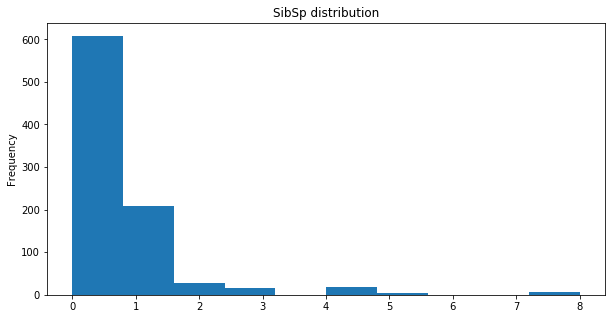

In [9]:
train["SibSp"].plot.hist(figsize=(10,5))
plt.title("SibSp distribution")
plt.show()

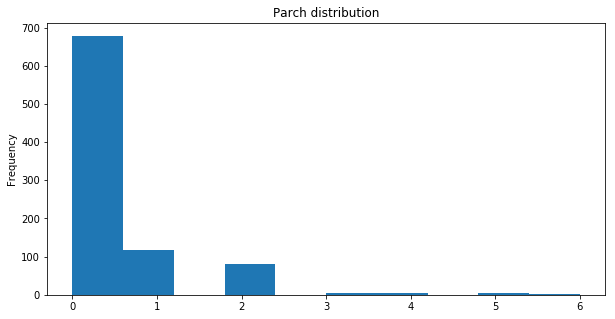

In [10]:
train["Parch"].plot.hist(figsize=(10,5))
plt.title("Parch distribution")
plt.show()

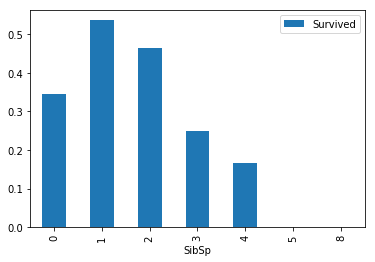

In [11]:
sibsp_pivot = train.pivot_table(index="SibSp",values="Survived")
sibsp_pivot.plot.bar()
plt.show()


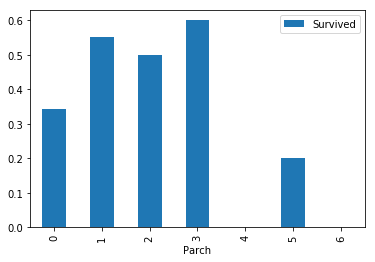

In [12]:
parch_pivot = train.pivot_table(index="Parch",values="Survived")
parch_pivot.plot.bar()
plt.show()

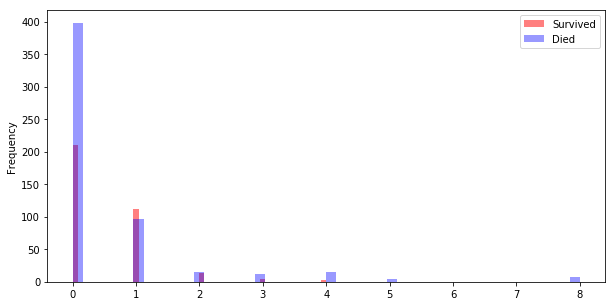

In [13]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["SibSp"].plot.hist(alpha=0.5,color='red',bins=50,figsize=(10,5))
died["SibSp"].plot.hist(alpha=0.4,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

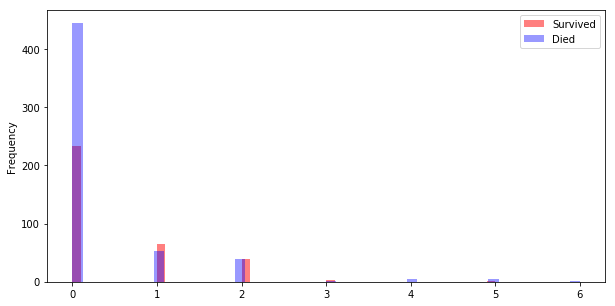

In [14]:
survived["Parch"].plot.hist(alpha=0.5,color='red',bins=50,figsize=(10,5))
died["Parch"].plot.hist(alpha=0.4,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

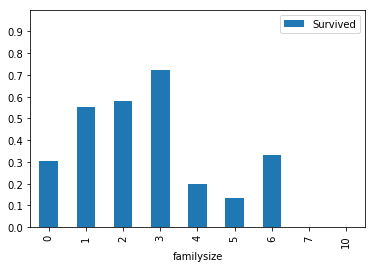

In [15]:
# counting all the family members of a person
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index='familysize',values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

#### Observations
Both columns contain integer, they have no missing value, and have valus ranging from :
- Sibssp: 0 to 8
- Parch: 0 to 6

From the first two histograms we can observe that most of the passengers of the Titanic were travelling alone, or with one familiar (either a sibling, a spouse or a children/parent). There were very few "big families" travelling altogether.

From the different histograms and bar plots we created we can also conclude that the people travelling alone were less likely to survive the disaster: indeed only 30% of the people travelling alone survived. Whereas people travelling with one or two family members were more likely to survive. Actually it's going along with the *Women and Children First"* code of conduct. Children were surely not let alone, and were at least put in the life boats with their mother, and possibly sometimes with their father too.

## Engineering New Features

As traveling alone or not seems to be a determinant feature to predict the survival of passengers, we will create a new column to add what seems to be valuable information. The new column will have 1 if the person is traveling alone, and 0 if he/she has one or more family members onboard.

In [16]:
def process_alone(df):
    mask1 = df["SibSp"]>0
    mask2 = df["Parch"]>0
    mask = mask1 | mask2
    df["isalone"]=1
    df["isalone"][mask]=0
    return df

In [17]:
train = process_alone(train)
holdout = process_alone(holdout)

/Users/louisboivin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Selecting the best-performing features

In [18]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier


In [19]:
def select_features(df):
    full_cols = (df.isnull().sum()==0).index
    df = df[full_cols]
    df = df.select_dtypes(include=['number'])
    all_y = df['Survived']
    all_X = df.drop(['Survived','PassengerId'],axis=1)
    rfc = RandomForestClassifier(random_state=1)
    selector = RFECV(rfc,cv=10)
    selector.fit(all_X,all_y)
    optimized_columns = all_X.columns[selector.support_]
    #print(optimized_columns)
    return optimized_columns

    

In [20]:
opt_cols=select_features(train)

## Selecting and tuning different algorithms

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [22]:
def select_model(df,features):
    all_X = df[features]
    all_y = df['Survived']
    L_dict = [
        {
        "name": "LogisticRegression",
        "estimator": LogisticRegression(),
        "hyperparameters":
            {
            "solver": ["newton-cg", "lbfgs", "liblinear"]    
            }

        },
        {
        "name": "KNeighborsClassifier",
        "estimator": KNeighborsClassifier(),
        "hyperparameters":
            {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
        },
        {
        "name": "RandomForestClassifier",
        "estimator": RandomForestClassifier(),
        "hyperparameters":
            {
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
            }   
        }
            ]
    for d in L_dict:
        print(d["name"])
        grid = GridSearchCV(d["estimator"],param_grid=d["hyperparameters"],cv=10)
        grid.fit(all_X,all_y)
        d["best_params"] = grid.best_params_
        d["best_score"] = grid.best_score_
        d["best_estimator"] = grid.best_estimator_
        print(grid.best_params_)
        print(grid.best_score_)
    return L_dict
                              


In [47]:
L_models = select_model(train,opt_cols)

LogisticRegression
{'solver': 'liblinear'}
0.820426487093
KNeighborsClassifier
{'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.775533108866
RandomForestClassifier
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 6}
0.836139169473


In [48]:
L_models[2]['best_estimator']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
def save_submission_file(holdout,model,features,filename='submission.csv'):
    holdout_no_id = holdout.drop(['PassengerId'],axis=1)
    holdout_no_id = holdout_no_id[features]
    holdout_predictions = model.predict(holdout_no_id)
    submission = pd.DataFrame({"PassengerId":holdout["PassengerId"],"Survived":holdout_predictions})
    submission.to_csv(filename,index=False)
    return

In [50]:
best_model = L_models[2]['best_estimator']
save_submission_file(holdout,best_model,opt_cols)

In [51]:
sub = pd.read_csv('submission.csv')
sub.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


## Submitting our first model

When using the best model found before :

`RandomForestClassifier
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 6}
0.836139169473`

with the features obtained in [20] : `opt_cols` on the test data set we got a *submission.csv* file, that we uploaded on Kaggle and we got the following results. 

![firstsubmission](first_submission.png) 